### Data preparation

Note: this notebook is prepared with a minimum effort and as such contains  
methodological shortcuts and omissions that are not relevant for the main
example.

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.metrics import roc_auc_score
from sklearn.inspection import permutation_importance
from scipy.stats import chi2_contingency
from optbinning import OptimalBinning

from utils import calculate_RWA, calculate_most_important_feature, calculate_hhi
import utils as ut

# Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [2]:
# Import the dataset
data = pd.read_csv('german_data.csv')

# Fix column names
data.columns = [' '.join(word.lower() for word in string.split()) for string in data.columns]
data.columns = [col.replace(' ', '_') for col in data.columns]
data.columns = [col.replace('/', '_') for col in data.columns]
data.columns = [col.replace('&_', '') for col in data.columns]
data.columns = [col.replace('(', '').replace(')', '') for col in data.columns]

# Fix formats
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [3]:
# Append synthetic date data for calibration purposes
p_good = [0.2, 0.2, 0.25, 0.25, 0.1]
p_bad = [0.2, 0.2, 0.2, 0.2, 0.2]

# Initialize a column for group numbers
data['year'] = 0

# Assign groups for target '1'
bad = data[data['target'] == 1].index
bad_years = np.random.choice(range(2015, 2020, 1), size=len(bad), p=p_bad)
data.loc[bad, 'year'] = bad_years

# Assign groups for target '0'
good = data[data['target'] == 0].index
good_years = np.random.choice(range(2015, 2020, 1), size=len(good), p=p_good)
data.loc[good, 'year'] = good_years

In [4]:
# Create config table
optbinning_config = {
    'account_balance': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'duration_of_credit_month': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'sex_marital_status': {'dtype': 'categorical', 'monotonic_trend': 'auto_asc_desc'},
    'type_of_apartment': {'dtype': 'categorical', 'monotonic_trend': 'auto_asc_desc'},
    'payment_status_of_previous_credit': {'dtype': 'categorical', 'monotonic_trend': 'auto_asc_desc'},
    'purpose': {'dtype': 'categorical', 'monotonic_trend': 'auto_asc_desc'},
    'credit_amount': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'value_savings_stocks': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'length_of_current_employment': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'instalment_per_cent': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'guarantors': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'duration_in_current_address': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'most_valuable_available_asset': {'dtype': 'categorical', 'monotonic_trend': 'auto_asc_desc'},
    'age_years': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'concurrent_credits': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'no_of_credits_at_this_bank': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'occupation': {'dtype': 'categorical', 'monotonic_trend': 'auto_asc_desc'},
    'no_of_dependents': {'dtype': 'numerical', 'monotonic_trend': 'auto_asc_desc'},
    'telephone': {'dtype': 'categorical', 'monotonic_trend': 'auto_asc_desc'},
    'foreign_worker': {'dtype': 'categorical', 'monotonic_trend': 'auto_asc_desc'}
}

risk_drivers = list(optbinning_config.keys())

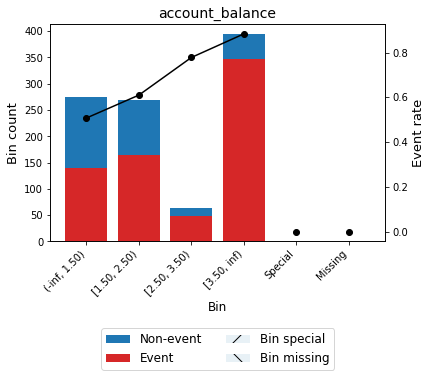

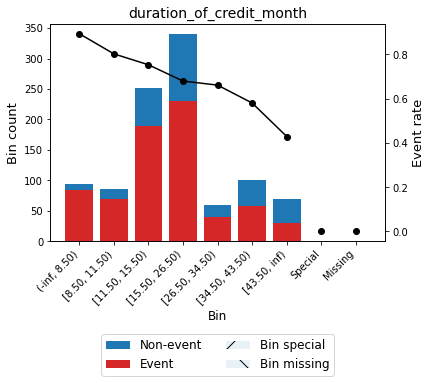

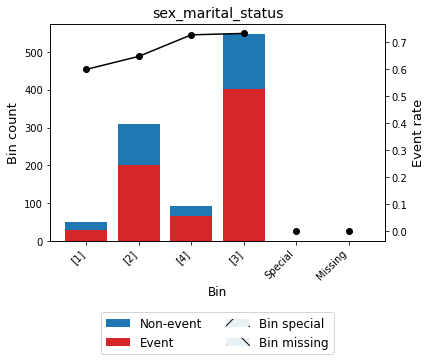

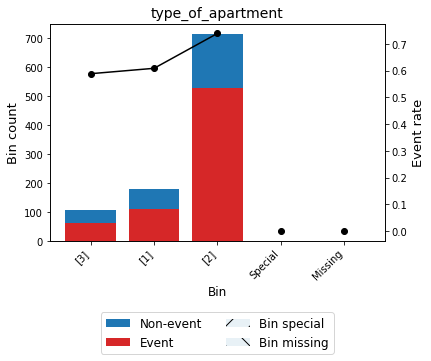

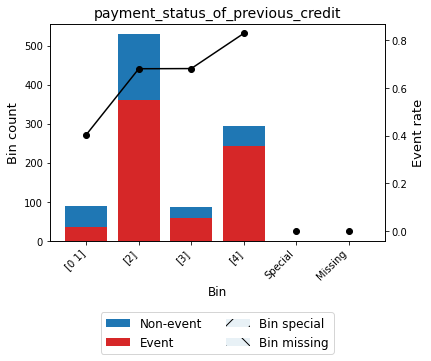

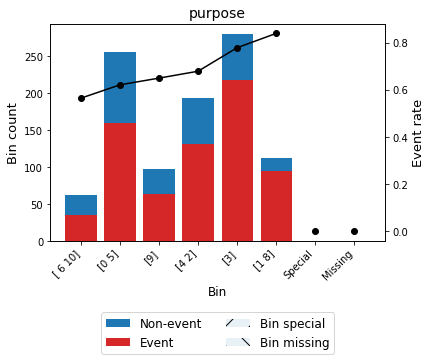

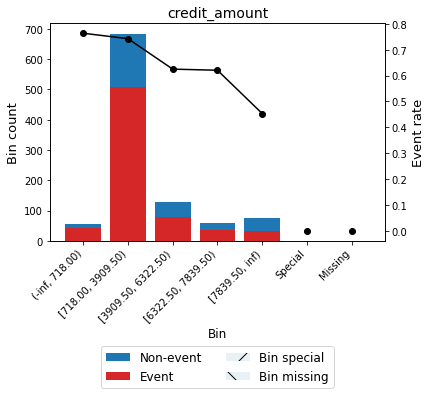

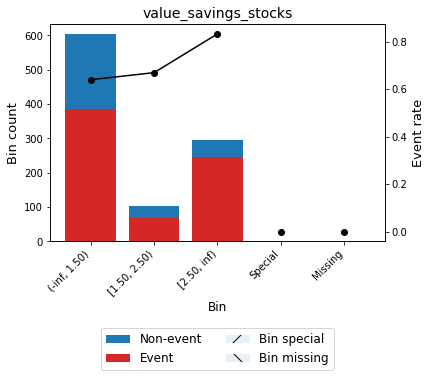

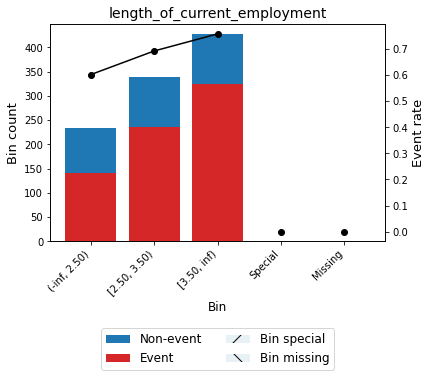

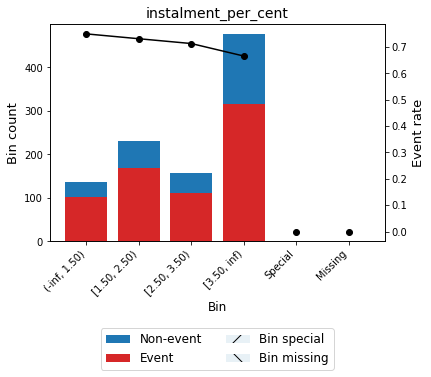

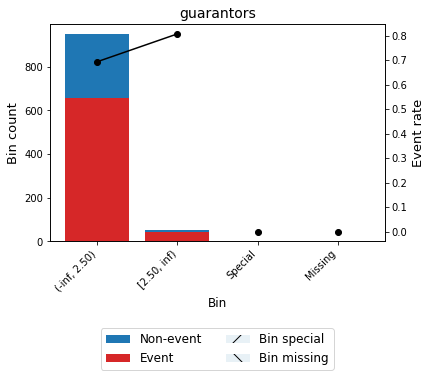

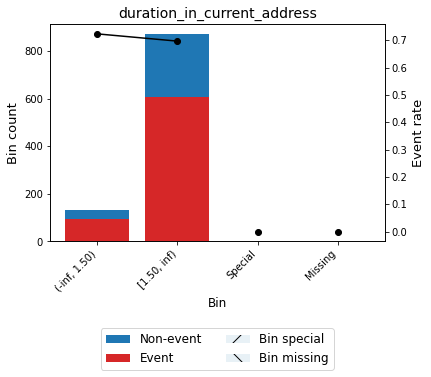

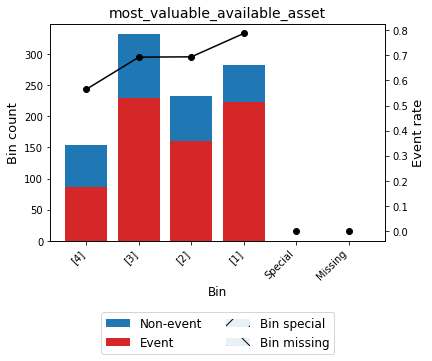

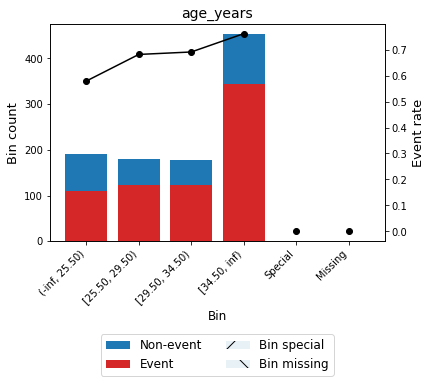

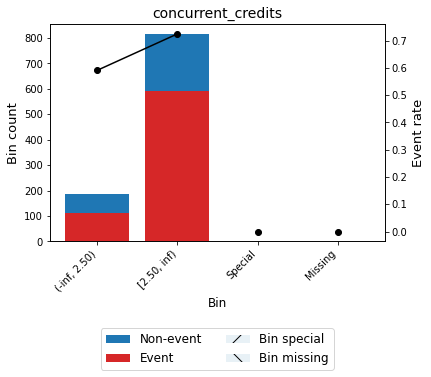

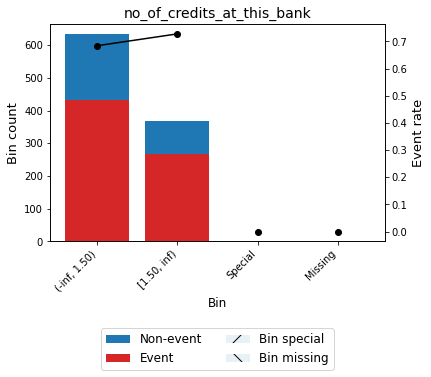

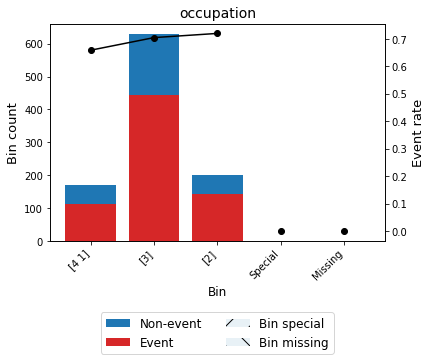

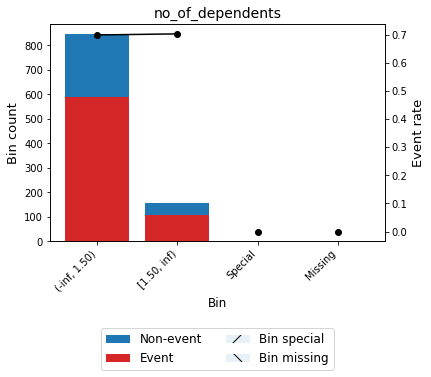

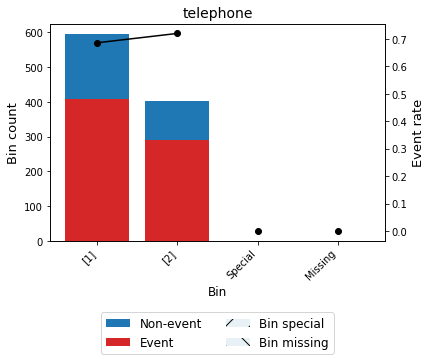

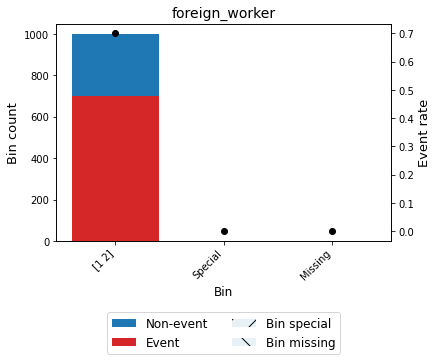

In [5]:
# Creating WOE encoding for each column and relevant stats
stats_df = pd.DataFrame()

for column, config in optbinning_config.items():
    binning = OptimalBinning(name=column,
                             # prebinning_method='uniform',
                             max_n_prebins=200,
                             dtype=config['dtype'], 
                             monotonic_trend=config['monotonic_trend'],
                             max_pvalue=None,
                             # prebin_size=0.05,
                             user_splits=None,)
    binning.fit(data[column], data['target'])

    # Create a WOE variable
    data[column + '_woe'] = binning.transform(data[column], metric="woe")

    # Binning Table for the variable
    binning_table_raw = binning.binning_table
    binning_table = binning.binning_table.build()
    binning_table_raw.analysis(pvalue_test="chi2", print_output=False)

    # Maximum shares
    filtered_data = binning_table[-binning_table['Bin'].isin(['Special', 'Missing'])][:-1]
    min_count_pct = filtered_data['Count (%)'].min()
    max_count_pct = filtered_data['Count (%)'].max()

    # Other stats
    iv = binning_table['IV'][:-1].sum()
    iv_no_missings = filtered_data['IV'].sum()
    gini = binning_table_raw.gini
    hhi_score = ut.hhi(binning_table['Count (%)'][:-1], normalized=False)
    num_bins = len(binning_table)
    raw_gini = ut.gini_coefficient(data, column, 'target')
    missing_share = data[column].isna().mean()
    missings_type, p_chi_square = ut.chi_square_test(data, column, 'target')

    # Create a temporary DataFrame for this iteration
    temp_df = pd.DataFrame({
        'Variable': [column], 
        'Quality Score': binning_table_raw.quality_score,
        'IV': [iv], 
        'IV_no_missings': [iv_no_missings],
        'Gini': [gini], 
        'Raw Gini': [raw_gini],
        'HHI': [hhi_score], 
        'Num Bins': [num_bins], 
        'Largest Bin Share': [max_count_pct], 
        'Smallest Bin Share': [min_count_pct],
        'Share of missings': [missing_share],
        'Type of missings': [missings_type],
        'Missings chi_square': [p_chi_square],
    })

    # Concatenate with the main DataFrame
    stats_df = pd.concat([stats_df, temp_df], ignore_index=True)

    # Show graph
    binning_table_raw.plot(metric="event_rate", show_bin_labels=True)

In [6]:
# Show results
pd.options.display.float_format = '{:,.2%}'.format
stats_df.sort_values(by='IV', ascending=False)

,Variable,Quality Score,IV,IV_no_missings,Gini,Raw Gini,HHI,Num Bins,Largest Bin Share,Smallest Bin Share,Share of missings,Type of missings,Missings chi_square
0,account_balance,53.27%,66.60%,66.60%,41.55%,41.55%,30.66%,7,39.40%,6.30%,0.00%,Uninformative missings,100.00%
4,payment_status_of_previous_credit,0.70%,29.18%,29.18%,25.31%,25.36%,38.24%,7,53.00%,8.80%,0.00%,Uninformative missings,100.00%
1,duration_of_credit_month,6.58%,28.90%,28.90%,27.45%,-25.72%,21.32%,10,34.00%,5.90%,0.00%,Uninformative missings,100.00%
7,value_savings_stocks,21.01%,19.10%,19.10%,19.55%,19.41%,46.07%,6,60.30%,10.30%,0.00%,Uninformative missings,100.00%
5,purpose,3.98%,16.76%,16.76%,22.09%,2.58%,20.70%,9,28.00%,6.20%,0.00%,Uninformative missings,100.00%
6,credit_amount,0.38%,14.93%,14.93%,17.09%,-10.97%,49.63%,8,68.40%,5.50%,0.00%,Uninformative missings,100.00%
12,most_valuable_available_asset,0.94%,11.26%,11.26%,17.07%,-17.07%,26.73%,7,33.20%,15.40%,0.00%,Uninformative missings,100.00%
13,age_years,4.64%,10.13%,10.13%,16.90%,14.26%,30.50%,7,45.30%,17.80%,0.00%,Uninformative missings,100.00%
3,type_of_apartment,5.12%,8.54%,8.54%,13.61%,2.28%,55.33%,6,71.40%,10.70%,0.00%,Uninformative missings,100.00%
8,length_of_current_employment,25.55%,8.29%,8.29%,15.38%,14.59%,35.20%,6,42.70%,23.40%,0.00%,Uninformative missings,100.00%


In [7]:
# Extract final dataset with meaningful variables
other_vars = ['target', 'year']
final_drivers = stats_df[(stats_df['Gini'] > 0.10) | (stats_df['IV'] > 0.10)]['Variable'].to_list()
final_drivers = [var + '_woe' for var in final_drivers]

data[other_vars + final_drivers].to_csv('prepared_dataset.csv', index=False)